<h2> <center> A demo showing how to run PREP with pyprep and a comparison with PREP's results in Matlab </center></h2>

We use sample EEG data from Physionet EEG Motor Movement/Imagery Dataset(https://physionet.org/content/eegmmidb/1.0.0/)

In [1]:
import mne
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from pyprep.prep_pipeline import PrepPipeline


mne.set_log_level("WARNING")

raw = mne.io.read_raw_edf("./pyprep./test/test_data/S004R01.edf", preload=True)
raw.rename_channels(lambda s: s.strip("."))
montage_kind = "standard_1020"

eeg_index = mne.pick_types(raw.info, eeg=True, eog=False, meg=False)
raw_copy = raw.copy()
ch_names = raw_copy.info["ch_names"]
ch_names_eeg = list(np.asarray(ch_names)[eeg_index])
sample_rate = raw_copy.info["sfreq"]

### Set PREP parameters and run PREP

Notes: we keep all the default parameter settings as described in [PREP paper](https://www.ncbi.nlm.nih.gov/pubmed/26150785) except one, the fraction of bad time windows (we change it from 0.01 to 0.1), because the EEG data is 60s long, which means it gots only 60 time windows. We think the algorithm will be too sensitive if using the default setting.

In [2]:
prep_params = {'ref_chs': ch_names_eeg,
               'reref_chs': ch_names_eeg, 'line_freqs': np.arange(60,sample_rate/2,60)}
prep = PrepPipeline(raw_copy, prep_params, montage_kind=montage_kind)
prep.fit()

2019-12-11 17:14:33,015 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['Af8', 'Ft8'], 'bad_by_hf_noise': ['Af3', 'Af8'], 'bad_by_correlation': ['Ft8'], 'bad_by_ransac': ['Ft8', 'P7'], 'bad_all': ['Ft8', 'Af3', 'Af8', 'P7']}
2019-12-11 17:14:34,648 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['Ft8', 'Af8'], 'bad_by_hf_noise': ['Af3', 'Af8'], 'bad_by_correlation': ['Af8', 'F8', 'C5', 'Ft8', 'Af3'], 'bad_by_ransac': ['Cp3', 'Af8', 'F8', 'Cp5', 'Cp4', 'Fc3', 'Tp7', 'C5', 'Ft8', 'P2', 'T9', 'P7', 'C3', 'Fc1'], 'bad_all': ['Af8', 'F8', 'Cp3', 'Cp5', 'Cp4', 'Fc3', 'Fc1', 'C5', 'Ft8', 'P2', 'T9', 'P7', 'C3', 'Tp7', 'Af3']}
2019-12-11 17:14:34,716 - pyprep.reference - INFO - Iterations: 1
2019-12-11 17:14:36,301 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['Ft8', 'Af8'], 'bad_by_hf_noise': ['Af3', 'Af8'], 'bad_by_correlation': ['Af

Found 25 uniquely bad channels.

0 by n/a: []

0 by flat: []

1 by deviation: ['Ft8']

0 by hf noise: []

2 by correl: ['Af3', 'Ft8']

2 by SNR ['Ft8', 'Af3']

0 by dropout: []

25 by ransac: ['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'C3', 'C1', 'C4', 'Cp2', 'Cp4', 'Af3', 'F7', 'F3', 'F1', 'F6', 'F8', 'Ft8', 'T9', 'Tp7', 'P7', 'P5', 'P3', 'P1', 'P4', 'Poz']


### Results

You can check the detected bad channels in each step of PREP

In [3]:
print("Bad channels: {}".format(prep.interpolated_channels))
print("Bad channels original: {}".format(prep.noisy_channels_original['bad_all']))
print("Bad channels after interpolation: {}".format(prep.still_noisy_channels))

Bad channels: ['F3', 'Cp4', 'Poz', 'C1', 'P7', 'Fcz', 'Af3', 'F6', 'Fc5', 'Fc2', 'F1', 'T9', 'Fc1', 'Tp7', 'P1', 'F8', 'P4', 'Fc3', 'Ft8', 'C3', 'P3', 'C4', 'P5', 'F7', 'Cp2']
Bad channels original: ['Ft8', 'Af3', 'Af8', 'P7']
Bad channels after interpolation: ['C6', 'Ft7', 'T10', 'C5']


Matlab's results:

Bad channels: Fc5, Fc3, Fc1, C3, Cp3, Cp4, Af3, Afz, Af8, F7, F5, F6, F8, Ft8, P7, P2

Bad channels original: Af3, Af4, Af7, Af8, Fp1, Fp2, Fpz, Ft8

Bad channels after interpolation: Cp5, Fp2, Af7, F1


### Validation



To validate each step of pyprep's results, we compare results after each step with the results from EEGLAB's PREP

To make it easy to compare, we rescale the EEG data to [-1, 1] (devided the data by maximum absolute value) when making the plot

Text(0.5, 0, 'Time(s)')

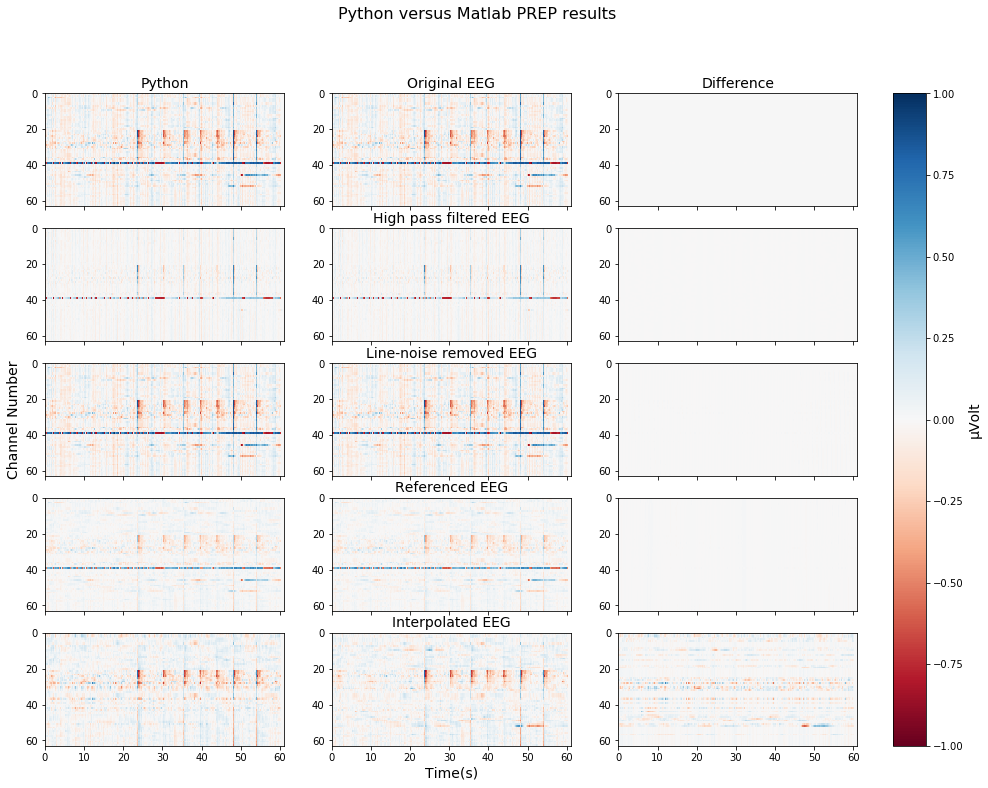

In [4]:
EEG_raw = raw_copy.get_data(picks='eeg')*1e6
EEG_raw_max = np.max(abs(EEG_raw), axis=None)
EEG_raw_matlab = sio.loadmat('./pyprep/examples/Matlab results/EEG_raw.mat')
EEG_raw_matlab = EEG_raw_matlab['save_data']
EEG_raw_diff = EEG_raw - EEG_raw_matlab
EEG_raw_mse = (EEG_raw_diff/EEG_raw_max**2).mean(axis=None)

fig, axs = plt.subplots(5, 3, 'all', figsize=(16,12))
plt.setp(fig, facecolor=[1, 1, 1])
fig.suptitle('Python versus Matlab PREP results', fontsize=16)

im = axs[0, 0].imshow(EEG_raw/EEG_raw_max, aspect='auto', extent=[0, (EEG_raw.shape[1] / sample_rate), 63, 0],
                      vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[0, 0].set_title('Python', fontsize=14)
axs[0, 1].imshow(EEG_raw_matlab/EEG_raw_max, aspect='auto', extent=[0, (EEG_raw_matlab.shape[1] / sample_rate), 63, 0],
                      vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[0, 1].set_title('Matlab', fontsize=14)
axs[0, 2].imshow(EEG_raw_diff/EEG_raw_max, aspect='auto', extent=[0, (EEG_raw_diff.shape[1] / sample_rate), 63, 0],
                      vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[0, 2].set_title('Difference', fontsize=14)
axs[0, 1].set_title('Original EEG', fontsize=14)
# axs[0, 0].set_ylabel('Channel Number', fontsize=14)
cb = fig.colorbar(im, ax=axs, fraction=0.05, pad=0.04)
cb.set_label('\u03BCVolt', fontsize=14)

EEG_new_matlab = sio.loadmat('./pyprep/examples/Matlab results/EEGNew.mat')
EEG_new_matlab = EEG_new_matlab['save_data']
EEG_new = prep.EEG_new
EEG_new_max = np.max(abs(EEG_new), axis=None)
EEG_new_diff = EEG_new - EEG_new_matlab
EEG_new_mse = ((EEG_new_diff/EEG_new_max)**2).mean(axis=None)
axs[1, 0].imshow(EEG_new/EEG_new_max, aspect='auto', extent=[0, (EEG_new.shape[1] / sample_rate), 63, 0],
              vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[1, 1].imshow(EEG_new_matlab/EEG_new_max, aspect='auto', extent=[0, (EEG_new_matlab.shape[1] / sample_rate), 63, 0],
              vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[1, 2].imshow(EEG_new_diff/EEG_new_max, aspect='auto', extent=[0, (EEG_new_diff.shape[1] / sample_rate), 63, 0],
              vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[1, 1].set_title('High pass filtered EEG', fontsize=14)
# axs[1, 0].set_ylabel('Channel Number', fontsize=14)

EEG_clean_matlab = sio.loadmat('./pyprep/examples/Matlab results/EEG.mat')
EEG_clean_matlab = EEG_clean_matlab['save_data']
EEG_clean = prep.EEG
EEG_max = np.max(abs(EEG_clean), axis=None)
EEG_diff = EEG_clean - EEG_clean_matlab
EEG_mse = ((EEG_diff/EEG_max)**2).mean(axis=None)
axs[2, 0].imshow(EEG_clean/EEG_max, aspect='auto', extent=[0, (EEG_clean.shape[1] / sample_rate), 63, 0],
              vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[2, 1].imshow(EEG_clean_matlab/EEG_max, aspect='auto', extent=[0, (EEG_clean_matlab.shape[1] / sample_rate), 63, 0],
              vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[2, 2].imshow(EEG_diff/EEG_max, aspect='auto', extent=[0, (EEG_diff.shape[1] / sample_rate), 63, 0],
              vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[2, 1].set_title('Line-noise removed EEG', fontsize=14)
axs[2, 0].set_ylabel('Channel Number', fontsize=14)

EEG = prep.EEG_before_interpolation
EEG_max = np.max(abs(EEG), axis=None)
EEG_ref_mat = sio.loadmat('./pyprep/examples/Matlab results/EEGref.mat')
EEG_ref_matlab = EEG_ref_mat['save_EEG']
reference_matlab = EEG_ref_mat['save_reference']
EEG_ref_diff = EEG - EEG_ref_matlab
EEG_ref_mse = ((EEG_ref_diff/EEG_max)**2).mean(axis=None)
reference_signal = prep.reference_before_interpolation
reference_max = np.max(abs(reference_signal), axis=None)
reference_diff = reference_signal - reference_matlab
reference_mse = ((reference_diff/reference_max)**2).mean(axis=None)
axs[3, 0].imshow(EEG/EEG_max, aspect='auto', extent=[0, (EEG.shape[1] / sample_rate), 63, 0],
              vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[3, 1].imshow(EEG_ref_matlab/EEG_max, aspect='auto', extent=[0, (EEG_ref_matlab.shape[1] / sample_rate), 63, 0],
              vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[3, 2].imshow(EEG_ref_diff/EEG_max, aspect='auto', extent=[0, (EEG_ref_diff.shape[1] / sample_rate), 63, 0],
              vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[3, 1].set_title('Referenced EEG', fontsize=14)
# axs[3, 0].set_ylabel('Channel Number', fontsize=14)

EEG_final = prep.raw.get_data()*1e6
EEG_final_max = np.max(abs(EEG_final), axis=None)
EEG_final_matlab = sio.loadmat('./pyprep/examples/Matlab results/EEGinterp.mat')
EEG_final_matlab = EEG_final_matlab['save_data']
EEG_final_diff = EEG_final - EEG_final_matlab
EEG_final_mse = ((EEG_final_diff/EEG_final_max)**2).mean(axis=None)
axs[4, 0].imshow(EEG_final/EEG_final_max, aspect='auto', extent=[0, (EEG_final.shape[1] / sample_rate), 63, 0],
              vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[4, 1].imshow(EEG_final_matlab/EEG_final_max, aspect='auto', extent=[0, (EEG_final_matlab.shape[1] / sample_rate), 63, 0],
              vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[4, 2].imshow(EEG_final_diff/EEG_final_max, aspect='auto', extent=[0, (EEG_final_diff.shape[1] / sample_rate), 63, 0],
              vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu'))
axs[4, 1].set_title('Interpolated EEG', fontsize=14)
# axs[4, 0].set_ylabel('Channel Number', fontsize=14)
axs[4, 1].set_xlabel('Time(s)', fontsize=14)

Mean square error of each step:

In [5]:
print("Raw data MSE: {}".format(EEG_raw_mse))
print("Filtered data MSE: {}".format(EEG_new_mse))
print("Line-noise removed data MSE: {}".format(EEG_mse))
print("Referenced data MSE: {}".format(EEG_ref_mse))
print("Interpolated data MSE: {}".format(EEG_final_mse))

Raw data MSE: 9.35740425704774e-22
Filtered data MSE: 2.0870483401721795e-06
Line-noise removed data MSE: 2.0146739820363056e-05
Referenced data MSE: 1.5964428263822837e-05
Interpolated data MSE: 0.004464951873361826


### Discussions

It can be seen the results match well on each step except the final step. This is due to the difference of find_noisy_channel functions, since the channels with relatively large error corrsponds to the channels that are only interpolated in Python or Matlab.

We think the differences mainly arise from

1. Difference in bad channels from Ransac criteria, including the random number generator
2. Difference in some internal functions of Python and Matlab(e.g., filter and interpolation function)